In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [2]:
# If CSV file
df = pd.read_csv("/content/wine.csv")

df.head()


,Type,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
# Drop ID column if present
if 'ID#' in df.columns or 'ID' in df.columns:
    df = df.drop(columns=['ID#'], errors='ignore')
    df = df.drop(columns=['ID'], errors='ignore')

# Keep only numeric features
num_df = df.select_dtypes(include=[np.number])

# Fill missing values (if any) with median
num_df = num_df.fillna(num_df.median())

print(num_df.describe())


             Type     Alcohol       Malic         Ash  Alcalinity   Magnesium  \
count  178.000000  178.000000  178.000000  178.000000  178.000000  178.000000   
mean     1.938202   13.000618    2.336348    2.366517   19.494944   99.741573   
std      0.775035    0.811827    1.117146    0.274344    3.339564   14.282484   
min      1.000000   11.030000    0.740000    1.360000   10.600000   70.000000   
25%      1.000000   12.362500    1.602500    2.210000   17.200000   88.000000   
50%      2.000000   13.050000    1.865000    2.360000   19.500000   98.000000   
75%      3.000000   13.677500    3.082500    2.557500   21.500000  107.000000   
max      3.000000   14.830000    5.800000    3.230000   30.000000  162.000000   

          Phenols  Flavanoids  Nonflavanoids  Proanthocyanins       Color  \
count  178.000000  178.000000     178.000000       178.000000  178.000000   
mean     2.295112    2.029270       0.361854         1.590899    5.058090   
std      0.625851    0.998859       0.1

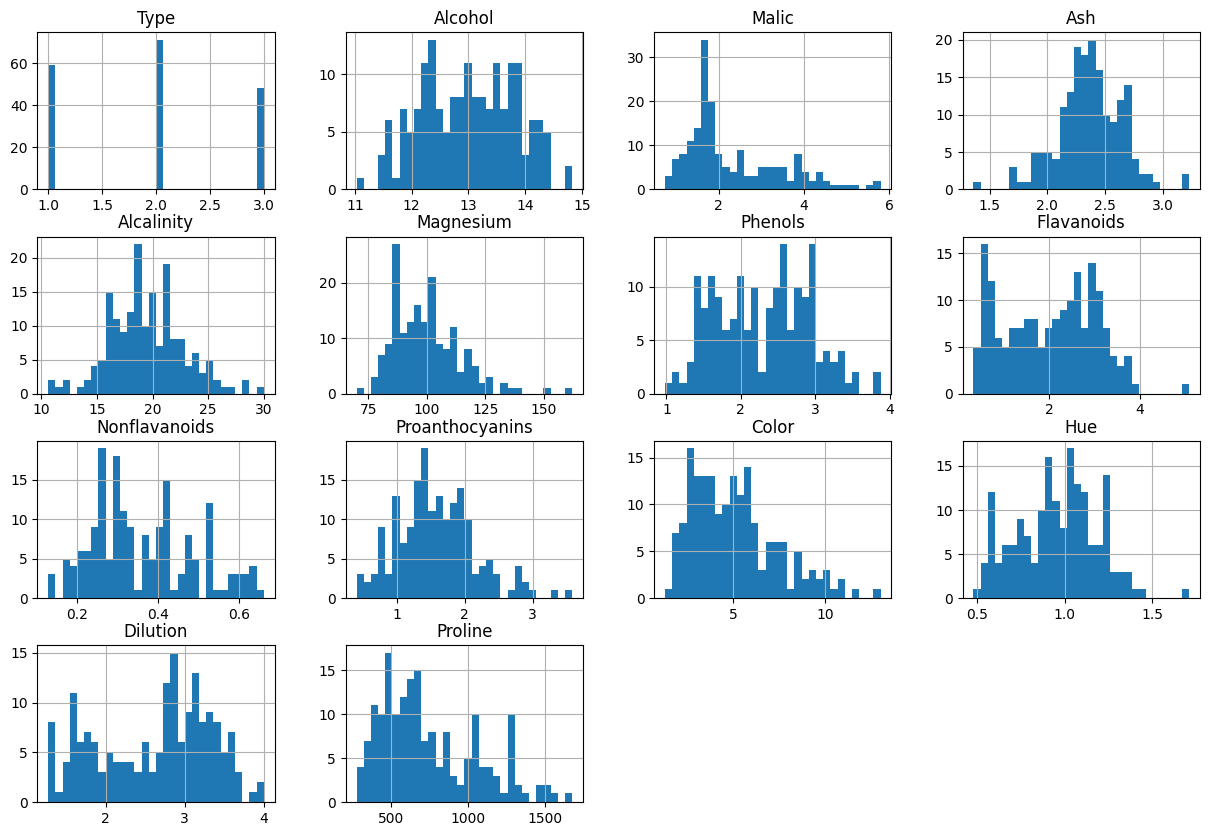

In [4]:
num_df.hist(figsize=(15, 10), bins=30)
plt.show()


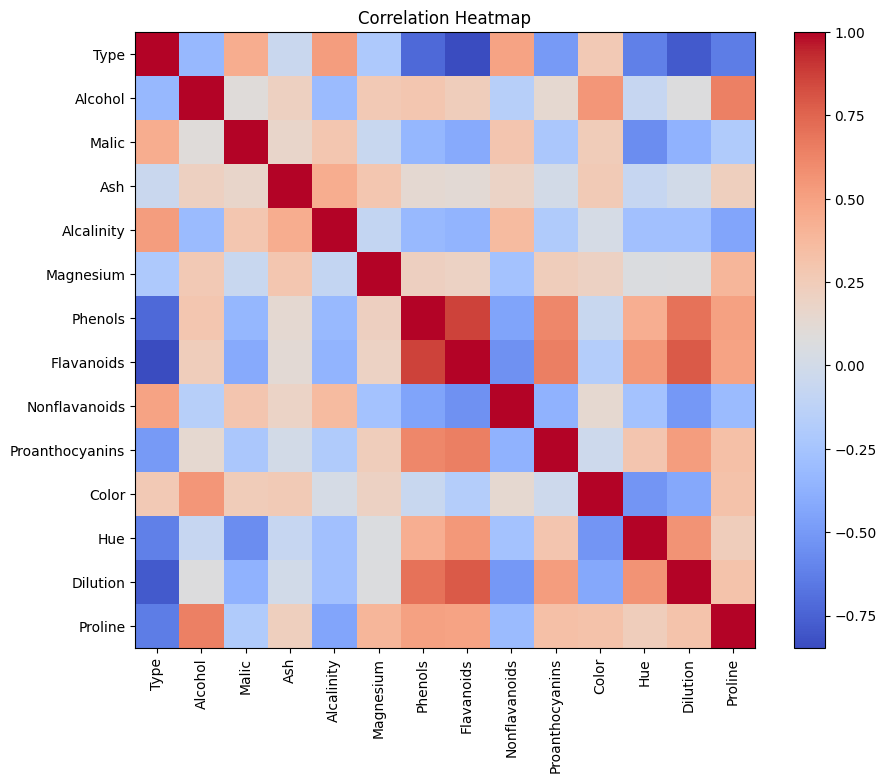

In [5]:
corr = num_df.corr()
plt.figure(figsize=(10,8))
plt.imshow(corr, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.show()


In [6]:
scaler = StandardScaler()
scaled = scaler.fit_transform(num_df)
scaled_df = pd.DataFrame(scaled, columns=num_df.columns)
scaled_df.head()


,Type,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,-1.213944,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,-1.213944,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,-1.213944,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,-1.213944,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,-1.213944,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


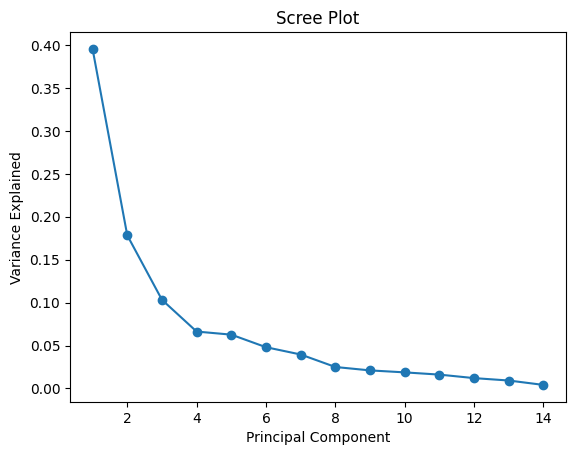

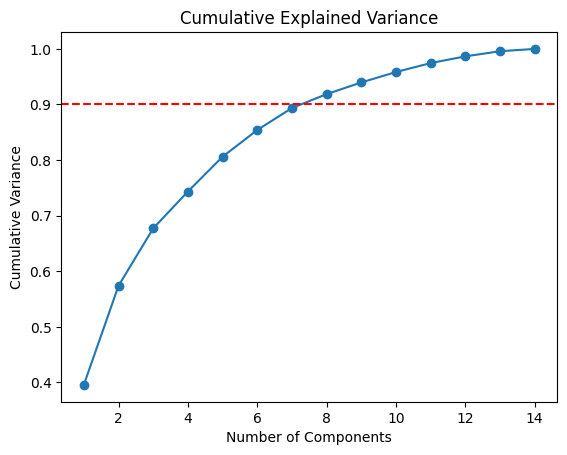

Chosen components: 8


In [7]:
# Fit PCA
pca = PCA()
pca.fit(scaled_df)

# Scree Plot
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_, marker='o')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.show()

# Cumulative Variance
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.show()

# Choose components explaining >=90%
n_components = np.argmax(cum_var >= 0.90) + 1
print("Chosen components:", n_components)

# Transform data
pca_final = PCA(n_components=n_components)
pca_data = pca_final.fit_transform(scaled_df)


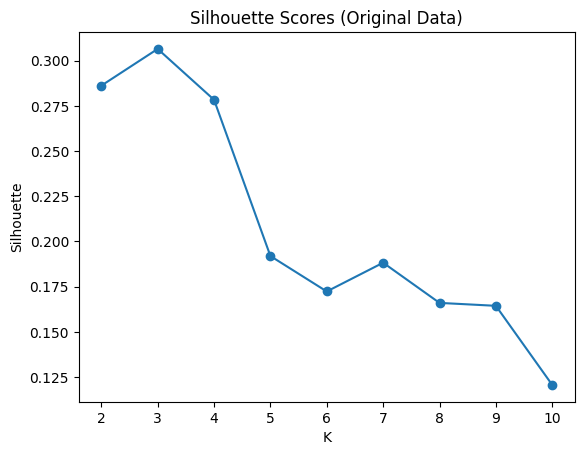

Best K (original): 3


In [8]:
sil_scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(scaled_df)
    sil_scores.append(silhouette_score(scaled_df, labels))

plt.plot(range(2, 11), sil_scores, marker='o')
plt.title("Silhouette Scores (Original Data)")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()

best_k_orig = np.argmax(sil_scores) + 2
print("Best K (original):", best_k_orig)


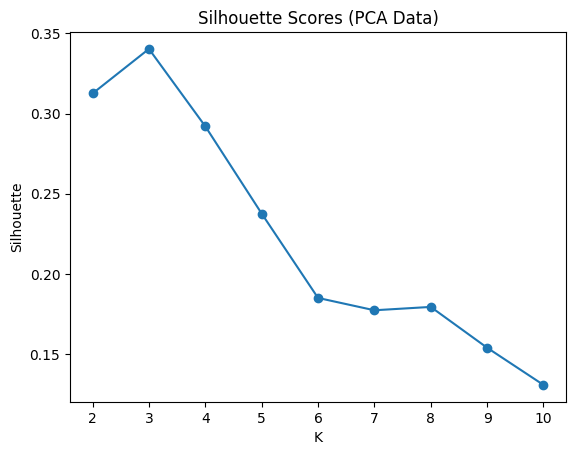

Best K (PCA): 3


In [9]:
sil_scores_pca = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(pca_data)
    sil_scores_pca.append(silhouette_score(pca_data, labels))

plt.plot(range(2, 11), sil_scores_pca, marker='o')
plt.title("Silhouette Scores (PCA Data)")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()

best_k_pca = np.argmax(sil_scores_pca) + 2
print("Best K (PCA):", best_k_pca)


In [10]:
# Original
km_orig = KMeans(n_clusters=best_k_orig, random_state=42)
orig_labels = km_orig.fit_predict(scaled_df)
print("Silhouette (original):", silhouette_score(scaled_df, orig_labels))
print("Davies-Bouldin (original):", davies_bouldin_score(scaled_df, orig_labels))

# PCA
km_pca = KMeans(n_clusters=best_k_pca, random_state=42)
pca_labels = km_pca.fit_predict(pca_data)
print("Silhouette (PCA):", silhouette_score(pca_data, pca_labels))
print("Davies-Bouldin (PCA):", davies_bouldin_score(pca_data, pca_labels))


Silhouette (original): 0.30648398324833453
Davies-Bouldin (original): 1.315707552261773
Silhouette (PCA): 0.3402428666857789
Davies-Bouldin (PCA): 1.1903042789637739


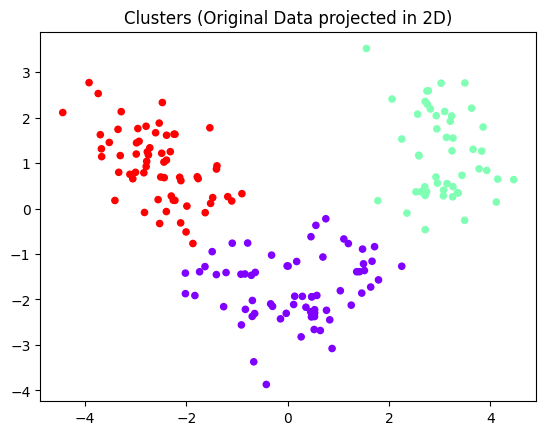

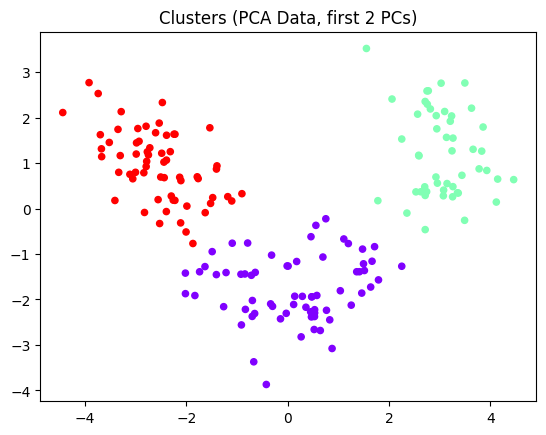

In [11]:
# Project into 2 PCs for plotting
pca2 = PCA(n_components=2)
proj2d = pca2.fit_transform(scaled_df)

plt.scatter(proj2d[:,0], proj2d[:,1], c=orig_labels, cmap="rainbow", s=20)
plt.title("Clusters (Original Data projected in 2D)")
plt.show()

plt.scatter(pca_data[:,0], pca_data[:,1], c=pca_labels, cmap="rainbow", s=20)
plt.title("Clusters (PCA Data, first 2 PCs)")
plt.show()
